## 1. Stigler's supplement

Consider Stigler's diet problem from Homework 1. To help further lower the cost of your diet, a friend offers to sell you calcium supplements. Each calcium pill
contains 500 mg of calcium.

**a)** What is the most you would be willing to pay per pill? _Hint:_ use duality!

**b)** Suppose you can buy calcium pills cost \$0.01 each.

**Solution:** Let's start by solving the problem as we did before, then compute the dual variable associated with calcium.

In [87]:
# STARTER CODE TO LOAD DATA FOR STIGLER'S DIET PROBLEM
using CSV
using DataFrames

# import Stigler's data set as a dataframe
raw = CSV.read("stigler.csv", DataFrame)

(m,n) = size(raw)  # m = number of rows, n = number of columns

n_nutrients = 2:n      # indices of columns containing nutrients (skip the first one)
n_foods = 2:m          # indices of rows containing food names (skip the two first ones)

nutrients = names(raw)[n_nutrients]   # the list of nutrients 
foods = raw[n_foods,1]                # the list of foods 

# Put the data about nutrients and foods into an array
data = Matrix(raw[n_foods,n_nutrients])

# lower[i] is the minimum daily requirement of nutrient i.
lower = Vector(raw[1,n_nutrients])
lower=NamedArray(lower,nutrients,"nutrients")           

# data[f,i] is the amount of nutrient i contained in food f.
raw_data = Array(raw[n_foods, n_nutrients])
data = NamedArray(
    raw_data,               # actual raw data as a 2D array
    (foods, nutrients),     # a tuple (pair) of arrays to label the (rows, cols)
    ("foods", "nutrients")  # we will designate the rows as "foods"
     )                       #  and the cols as "nutrients"

77×9 Named Matrix{Float64}
        foods ╲ nutrients │     Calories (1000)  …   Ascorbic Acid (mg)
──────────────────────────┼────────────────────────────────────────────
"Wheat Flour (Enriched)"  │                44.7  …                  0.0
"Macaroni"                │                11.6                     0.0
"Wheat Cereal (Enriched)" │                11.8                     0.0
"Corn Flakes"             │                11.4                     0.0
"Corn Meal"               │                36.0                     0.0
"Hominy Grits"            │                28.6                     0.0
"Rice"                    │                21.2                     0.0
"Rolled Oats"             │                25.3                     0.0
"White Bread (Enriched)"  │                15.0                     0.0
"Whole Wheat Bread"       │                12.2                     0.0
"Rye Bread"               │                12.4                     0.0
⋮                                    

In [82]:
# Write as a linear program and solve!

using JuMP,Clp
m = Model(with_optimizer(Clp.Optimizer))

@variable(m, consumption[foods] >= 0)
@constraint(m, nutrient_constraint[j in nutrients],sum(data[i,j] * consumption[i] for i in foods) >= lower[j])
@objective(m, Min, sum(consumption))

optimize!(m)
println("The optimal (daily) diet is:")
diet = JuMP.value.(consumption)
for i in foods
    if diet[i] > 1e-6
        println(i, ": ", diet[i])
    end
end
println()
println("The cost per year is: \$", 365*JuMP.objective_value(m))

# the price of calcium (the dual variable is in $/g, so divide by 2 to get $/500mg.)
calcium_price = JuMP.dual(nutrient_constraint["Calcium (g)"]) / 2
println("The price of calcium is \$", calcium_price, " per 500mg pill.")

The optimal (daily) diet is:
Wheat Flour (Enriched): 0.02951906167648827
Liver (Beef): 0.0018925572907052643
Cabbage: 0.011214435246144865
Spinach: 0.005007660466725203
Navy Beans, Dried: 0.061028563526693246

The cost per year is: $39.66173154546625
The price of calcium is $0.015868856722818517 per 500mg pill.
Coin0506I Presolve 9 (0) rows, 76 (-1) columns and 569 (-1) elements
Clp0006I 0  Obj 0 Primal inf 5.1310537 (9)
Clp0006I 6  Obj 0.10866228
Clp0000I Optimal - objective value 0.10866228
Coin0511I After Postsolve, objective 0.10866228, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 0.1086622782 - 6 iterations time 0.002, Presolve 0.00


Therefore, a calcium pill is worth about 1.6 cents. It is worth buying them as long as they are cheaper than this. Let's re-solve the problem by adding calcium pills as a food option and seeing what happens.

In [83]:
# add a new food item and its nutrient content
# if one pill (0.5g) costs $0.01, then $1 buys us 50g. 
# calcium is the third nutrient in the list, so we have:
foods2 = [foods; "Calcium supplement"]
raw2 = [raw_data; [0 0 50 0 0 0 0 0 0]]

# data[f,i] is the amount of nutrient i contained in food f.
data2 = NamedArray(raw2, (foods2, nutrients), ("foods", "nutrients") );


using JuMP,Clp
m = Model(with_optimizer(Clp.Optimizer))

@variable(m, consumption[foods2] >= 0)
@constraint(m, nutrient_constraint[j in nutrients],
    sum(data2[i,j] * consumption[i] for i in foods2) >= lower[j])
@objective(m, Min, sum(consumption))

optimize!(m)
println("The optimal (daily) diet is:")
diet = JuMP.value.(consumption)
for i in foods2
    if diet[i] > 1e-6
        println(i, ": ", diet[i])
    end
end
println()
println("The cost per year is: \$", 365*JuMP.objective_value(m))

The optimal (daily) diet is:
Wheat Flour (Enriched): 0.06598060307911847
Liver (Beef): 0.00784433892120114
Cabbage: 0.011195027632464827
Spinach: 0.003911295356684479
Calcium supplement: 0.012433796310553268

The cost per year is: $36.9982473745081
Coin0506I Presolve 9 (0) rows, 77 (-1) columns and 570 (-1) elements
Clp0006I 0  Obj 0 Primal inf 4.7027054 (9)
Clp0006I 5  Obj 0.10136506
Clp0000I Optimal - objective value 0.10136506
Coin0511I After Postsolve, objective 0.10136506, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 0.1013650613 - 5 iterations time 0.002, Presolve 0.00


**Note:** This optimal solution only costs us 37 USD per year, which is 2.66 USD cheaper than if we didn't access to the calcium supplements. Our optimal solution requires 0.01243 USD of calcium supplements per day, which amounts to about 1.24 pills per day.

## 2. Dual interpretation
Suppose $t \in [0,2\pi]$ is a parameter. Consider the following LP:
\begin{align*}
\underset{p,q,r,s}{\text{minimize}}\qquad& p+q+r+s\\
\text{subject to:}\qquad& p-r = \cos(t)\\
& q-s = \sin(t)\\
& p,q,r,s \ge 0
\end{align*}

**a)** Plot the optimal objective of this LP as a function of $t$. Can you explain what you see?
_Hint:_ you can do this by looping over values of $t$, and solving a separate LP for each different value of $t$. To interpret what you're seeing, you may want to separately consider the cases where $\cos(t)$ and $\sin(t)$ are positive or negative (four cases).

**b)** Find the dual LP and interpret it geometrically. Does this agree with the solution of part **a)**?

**Solution to part a:**

In [84]:
using JuMP, PyPlot, Clp

Npts = 101
tvals = range(0,stop=2*pi,length=Npts)
optvals = zeros(Npts)

for (i,t) in enumerate(tvals)
    m = Model(with_optimizer(Clp.Optimizer))
    @variable(m, p >= 0)
    @variable(m, q >= 0)
    @variable(m, r >= 0)
    @variable(m, s >= 0)
    @constraint(m, p - r == cos(t))
    @constraint(m, q - s == sin(t))
    @objective(m, Min, p + q + r + s)
    optimize!(m)
    optvals[i] = JuMP.objective_value(m)
end

Coin0506I Presolve 0 (-2) rows, 0 (-4) columns and 0 (-4) elements
Clp3002W Empty problem - 0 rows, 0 columns and 0 elements
Clp0000I Optimal - objective value 1
Coin0511I After Postsolve, objective 1, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 1 - 0 iterations time 0.002, Presolve 0.00
Coin0506I Presolve 0 (-2) rows, 0 (-4) columns and 0 (-4) elements
Clp3002W Empty problem - 0 rows, 0 columns and 0 elements
Clp0000I Optimal - objective value 1.0608172
Coin0511I After Postsolve, objective 1.0608172, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 1.060817248 - 0 iterations time 0.002, Presolve 0.00
Coin0506I Presolve 0 (-2) rows, 0 (-4) columns and 0 (-4) elements
Clp3002W Empty problem - 0 rows, 0 columns and 0 elements
Clp0000I Optimal - objective value 1.1174479
Coin0511I After Postsolve, objective 1.1174479, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 1.117447935 - 0 iterations time 0.002, Presolve 0.00
Coi

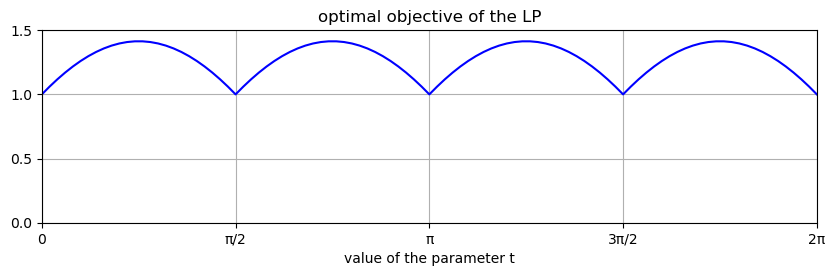

PyObject Text(0.5, 1.0, 'optimal objective of the LP')

In [85]:
figure(figsize=(10,2.5))
plot( tvals, optvals, "b-" )
xticks(0:π/2:2π)
yticks(0:0.5:1.5)
ylim([0,1.5])
xlim([0,2π])
grid()
g = gca()
g.set_xticklabels(["0","π/2","π","3π/2","2π"])
xlabel("value of the parameter t")
title("optimal objective of the LP")

**Explanation:** If we consider the case where $0 \le t \le \pi/2$, then both $\cos(t)$ and $\sin(t)$ are nonnegative. If we substitute $p=\cos(t)+r$ and $q=\sin(t)+s$ (which is an admissible thing to do since $p,q > 0$ for all $t$ in the interval), the optimization problem becomes:
\begin{align*}
\underset{r,s}{\text{minimize}}\qquad& \cos(t)+\sin(t)+2r+2s\\
\text{subject to:}\qquad& r,s \ge 0
\end{align*}
Since $t$ is a constant, the solution is clearly to set $r=s=0$, whereby the optimal value is $\cos(t)+\sin(t)$. If we consider the case $\pi/2 \le t \le \pi$, then $\cos(t)\le 0$ and $\sin(t)\ge 0$. In this case, substitute $r = p-\cos(t)$ and $q=\sin(t)+s$. Slightly different from the previous case because $\cos(t)\le 0$ so we want to ensure $r\ge 0$ for all $t$. This leads to:
\begin{align*}
\underset{p,s}{\text{minimize}}\qquad& -\cos(t)+\sin(t)+2p+2s\\
\text{subject to:}\qquad& p,s \ge 0
\end{align*}
Again, the solution is to set $p=r=0$, whereby the optimal value is $-\cos(t)+\sin(t)$. We can continue in this manner and we find that the four intervals correspond to the four combinations of signs. Here is a plot showing each of them (observe: the optimal value of the LP is the max of these functions!)

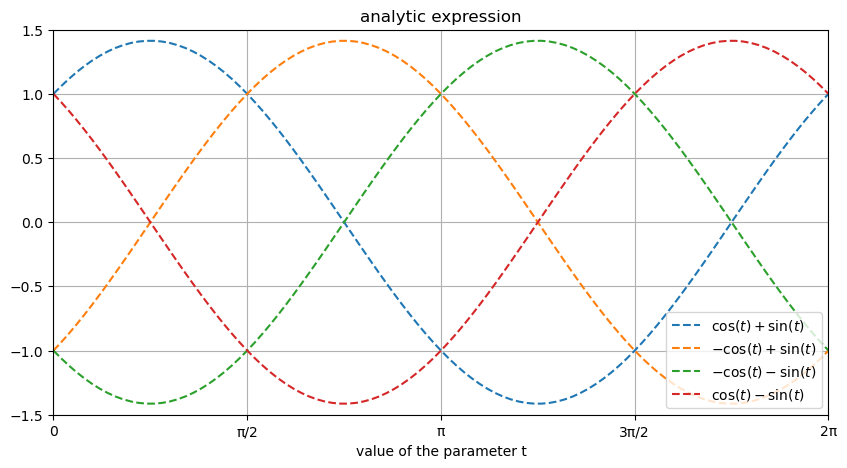

In [86]:
figure(figsize=(10,5))
t = tvals
plot(t, cos.(t)+sin.(t),"--")
plot(t,-cos.(t)+sin.(t),"--")
plot(t,-cos.(t)-sin.(t),"--")
plot(t, cos.(t)-sin.(t),"--")
legend([L"\cos(t)+\sin(t)",L"-\cos(t)+\sin(t)",L"-\cos(t)-\sin(t)",L"\cos(t)-\sin(t)"],loc="lower right")
xticks(0:π/2:2π)
ylim([-1.5,1.5])
xlim([0,2π])
grid()
g = gca()
g.set_xticklabels(["0","π/2","π","3π/2","2π"])
xlabel("value of the parameter t")
title("analytic expression")
;

**Solution to part b:** For the dual, we'll use variables $x,y$ which will correspond to the $\cos$ and $\sin$ constraints respectively. Here is the dual of the original LP: 
\begin{align*}
\underset{x,y}{\text{maximize}}\qquad& x \cos(t) + y \sin(t) \\
\text{subject to:}\qquad& -1 \le x \le 1 \\
& -1 \le y \le 1
\end{align*}
The feasible set is a square centered at the origin. The objective function is linear and its normal vector is in the direction $(\cos(t),\sin(t))$, which is a vector pointed at an angle $t$ (measured from the $x$-axis). Therefore it's clear that when $0\le t \le \pi/2$, the solution is at $x=1,y=1$. When $\pi/2\le t\le \pi$, the solution is at $x=-1,y=1$, and so on. This yields the same optimal objective values as those found in the previous part!

## 3. Max-flow to min-cost

Consider the graph given in the HW. We wish to maximize the flow from the source to the sink nodes. Using the trick learned in Lecture 5, you will formulate this problem as a min-cost problem. **DO NOT use Julia to solve the problem.** Simply state the answers to the questions.

**a)** Recall the min-cost model from class:

$$\begin{align*}
    \max_x & \quad c^\top x \\
    \text{subject to} & \quad Ax = b \\
    & \quad p \leq x \leq q
\end{align*}$$

Remember that $A$ (the incidence matrix) is a property of the graph, not the specific problem. Find $A$ for this graph. What is $x$? What are $p$ and $q$?

**b)** Modify the graph using the trick to formulate a min-cost problem (which is equivalent to the max-flow problem which maximizes the flow from the source to the sink). What is your new $x$, $p$, and $q$? What are $c$ and $b$?

Remember from Lecture 7 that the dual problem of this problem is the minimum cut problem. 

**c)** What is the minimum cut of the this graph (you can just look at the graph to determine the minimum cut, and either give the solution either graphically or as a list of the edges in the cut)? What can you say about the values of the dual variables corresponding to the capacity constraints $\lambda_{ij}$ and the nodal balance constraints $\mu_i$?

**Solution for part a:**

For this part, we base the solution on the original graph in the figure (without any added edges). A more clear problem definition would have asked you to consider the max-flow problem:

$$\begin{align*}
    \max_{x,b_1,b_5}& \quad b_1 \\
    \text{subject to} & \quad Ax = b \\
    & \quad p \leq x \leq q
\end{align*}$$

As you can see, the only change between the standard max-flow and min-cost flow problem is that the max-flow problem has the injected flow $b$ at the start and the end node as optimization variables. These are not known parameters, but are what we are trying to optimize! 

We will give the solution for this problem (which is only really a change in the variables and the objective relative to the min-cost problem you were given. $A$, $x$, $p$ and $q$ stay the same).

--------------------

To find $A, x, p$ and $q$, we first label all the nodes from left-to-right, top-to-bottom as 1, 2, ...

First we define the *decision variables*, $x$, which represent the flow on each edge. Thus, we define $x$ as

$$x = \left[\begin{matrix}
    x_{12} \\
    x_{23} \\
    x_{34} \\
    x_{45} \\
    x_{16} \\
    x_{63} \\
    x_{67} \\
    x_{75}
\end{matrix}\right]$$

where each variable corresponds to one edge.

To determine the matrix $A$, recall that $A$ is an *incidence matrix*. Each row of $A$ indicates a balance equation for a given node (the number of columns corresponds to the number of edges). For example, the first node has two edges leaving to node 2 and 6, and it has no incoming nodes. It has balance equation:

$$x_{12} + x_{16} = b_1$$

(Note that we do not know a value for $b_1$ yet!) We can generate similar equations for each node to find

$$A = \left[\begin{matrix}
  %x 12   23   34   45   16   63   67   75
      1 &  0 &  0 &  0 &  1 &  0 &  0 &  0 \\ % node 1
     -1 &  1 &  0 &  0 &  0 &  0 &  0 &  0 \\ % node 2
      0 & -1 &  1 &  0 &  0 & -1 &  0 &  0 \\ % node 3
      0 &  0 & -1 &  1 &  0 &  0 &  0 &  0 \\ % node 4
      0 &  0 &  0 & -1 &  0 &  0 &  0 & -1 \\ % node 5
      0 &  0 &  0 &  0 & -1 &  1 &  1 &  0 \\ % node 6
      0 &  0 &  0 &  0 &  0 &  0 & -1 &  1    % node 7
\end{matrix}\right]$$

Also, note that for each column, we have exactly one $1$ and one $-1$ entry, at the row corresponding to the node the edge is *leaving* from and the node the edge is *arriving* to, respectively. 


The constraints involving $p$ and $q$ are *capacity constraints*, which represents limitations on how much flow can flow across each edge. The parameters $p$ and $q$ indicate the lower and upper bounds for the flow on each edge (i.e., how small or large is the flow allowed to be). 

First, we know that the flow is not allowed to be negative, as we do not want the flow to go against the direction of the edge. Therefore, the lower bounds $p=0$. Second, the maximum capacity are given by the edge capacities (green numbers in the graph). Taken together, we get the following values for $p$ and $q$,

$$p = \left[\begin{matrix}
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0
\end{matrix}\right]
\leq x \leq q = \left[\begin{matrix}
    3 \\
    1 \\
    3 \\
    2 \\
    2 \\
    4 \\
    2 \\
    3
\end{matrix}\right]$$

Note the difference between the edge *capacities*, which are limitations on how much flow can go through a given line, and the edge *costs*, which is related to the price you have to pay for the flow through a given line. In this problem, you were given the edge capacities. The edge costs can be assumed to be zero, since what we really care about is getting as much flow as possible from $b_1$ (source) to $b_5$ (sink) (so it makes sense not to penalize ourselves for having more flow through an edge).

**Solution for part b:**

In the max-flow problem we want to maximize the flow from node $b_1$ to $b_5$, but we want to formulate the problem as a min-cost problem with the edge flows $x$ as variables. Since we know that the system must be balanced and node 1 and node 5 are the only two nodes where there is injection of flow, we know that $b_5=-b_1$, i.e., the flow generated at the first node will be consumed at the last node. 

Wait a moment - this sounds a lot like the flow across one of our edges (i.e. $b_5 = -b_1$ looks like a balance equation)?? The flow leaving the sending end is equal to the flow entering the receiving end (and since it is on the receiving end, it has a minus in front).

Indeed, the "trick" for reformulating a max-flow problem to a min-cost problem is to add a feedback edge from node 5 (sink) to node 1 (source) with a cost of -1 (see note below). Note that all the other edges are assigned a cost of 0.

$$\begin{align*}
    \min_x & \quad -x_{51} \\
    \text{subject to} & \quad Ax = b \\
    & \quad p \leq x \leq q
\end{align*}$$

To minimize the cost of the flow, the problem will now try to maximize the flow from $x_{51}$, which is exactly what we wanted.

(Alternatively, you could add a cost of +1 is you were considering the max-cost form of the problem: 

$$\begin{align*}
    \max_x & \quad x_{51} \\
    \text{subject to} & \quad Ax = b \\
    & \quad p \leq x \leq q
\end{align*}$$

As we discussed in the lecture, it is possible to flip the objective function from a min to a max by multiplying by -1!)

With this problem, we have a new $x$, $p$, and $q$ (note that there is one more edge):

$$p = \left[\begin{matrix}
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0
\end{matrix}\right]
\leq x = \left[\begin{matrix}
    x_{12} \\
    x_{23} \\
    x_{34} \\
    x_{45} \\
    x_{16} \\
    x_{63} \\
    x_{67} \\
    x_{75} \\
    x_{51}
\end{matrix}\right]
\leq q = \left[\begin{matrix}
    3 \\
    1 \\
    3 \\
    2 \\
    2 \\
    4 \\
    2 \\
    3 \\
    +\infty
\end{matrix}\right]$$

Here the $+\infty$ in $q$ indicates that there is no limit to the flow on the feedback edge (i.e. no constraint). Our cost vector is

$$c = \left[\begin{matrix}
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    -1
\end{matrix}\right]$$

Every node is now a relay, and completely balanced, so

$$b = \left[\begin{matrix}
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0
\end{matrix}\right]$$

As you can see, all the $b$'s are known in this problem, as is required for the problem to be a standard min-cost problem.

And matrix A is:
$$A = \left[\begin{matrix}
  %x 12   23   34   45   16   63   67   75   51
      1 &  0 &  0 &  0 &  1 &  0 &  0 &  0 &  -1 \\ % node 1
     -1 &  1 &  0 &  0 &  0 &  0 &  0 &  0 &  0 \\ % node 2
      0 & -1 &  1 &  0 &  0 & -1 &  0 &  0 &  0 \\ % node 3
      0 &  0 & -1 &  1 &  0 &  0 &  0 &  0 &  0 \\ % node 4
      0 &  0 &  0 & -1 &  0 &  0 &  0 & -1 &  0 \\ % node 5
      0 &  0 &  0 &  0 & -1 &  1 &  1 &  0 &  0 \\ % node 6
      0 &  0 &  0 &  0 &  0 &  0 & -1 &  1 &  1    % node 7
\end{matrix}\right]$$

**Solution for part c:**

In lecture 7, we discussed duality in the context of network flow problems. We saw that the dual of the min-cost problem (and therefore also of the max-flow problem) is what is called the min-cut problem. To get a *cut*, you partition the graph into two groups of nodes, where the start and the end node are in separate groups. The cut is the value of all the edge capacities on the edges connecting the two groups. The *min-cut* is the cut which gives you the minimum edge capacity between the two groups. For larger problems, you can find this solution by solving the dual of the min-flow problem. However, in this case, you can solve it by just looking at the graph and deciding which edges you want to "cut".

-----------

The min-cut solution is obtained by drawing a line through edges that you want to cut. After removing the cut edges, the graph should be split into two distinct pieces. We add up all the capacities of the cut edges to determine the objective function's value (we want to minimize this). For example, cutting $x_{45}$ and $x_{75}$ (both edges into the sink) will split the graph into two pieces, and the cost associated is $3 + 2 = 5$. *By inspection, we see that the min-cut solution is to cut edges $x_{23}$ and $x_{16}$ for an overall cost of $2 + 1 = 3$.*

In the dual problem, the value of the dual variable $\lambda_{ij}$ (which is associated to each edge constraint $x\leq q$) indicates whether an edge is cut or not. As we saw in the lecture, it is 1 for a cut edge and 0 for an uncut edge. So, $\lambda_{23} = \lambda_{16} = 1$ and $\lambda_{ij} = 0$ for all other $i, j$.

$\mu_i$ is the dual variable associated with the nodal balance constraint (i.e., we have one $\mu_i$ per node). From the lecture we know the following:
Our problem is such that $\mu_j - \mu_i = \lambda_{ij}$, $\mu_1 = 0$ (source), and $\mu_5 = 1$ (sink). 
We also know that all the dual variables have integer values. Why?? This follows from the fact that (i) the matrix $A$ is an incidence matrix and therefore totally unimodular, and (ii) the cost function parameters $c$ in the primal problem have integer values.

Since we know $\mu_1$, $\mu_5$, and all the $\lambda_{ij}$'s, we can find the remaining $\mu_i$. For example,

$$\mu_2 - \mu_1 = \lambda_{12} \implies \mu_2 = 0$$

Repeating this process, we see that all the nodes to the left (before) the cut have $\mu_i = 0$, and all the nodes to the right (after) the cut have $\mu_i = 1$. So,

$$\mu = \left[\begin{matrix}
    0 \\
    0 \\
    1 \\
    1 \\
    1 \\
    1 \\
    1
\end{matrix}\right]$$